# AGDC-V2 API for WOfS  (unification merged)

Last modified & tested OK on 2016-06-21 

Fei Zhang

##  Outstanding Issues & Questions


### Bug: list_cells() the platforms can be 1 or 3 or more, but cannot be two satellites like 
qdict={'latitude': (-36.0, -35.0), 'platform': ['LANDSAT_5', 'LANDSAT_7'], 'longitude': (149.01, 150.1), 'time': ('1990-01-01', '2016-03-31')}

### gw constructor argument product repeated in function?

nbar_tiles = gw.list_tiles(product='ls7_nbar_albers')

### Why not keep the function list_tiles_by_cells( cell_list)??

### load nbar-pqa tile data over a cell at a timestamp

nbar_data = gw.load(cell, tile)  # is cell really necessary?? not really. Modified to new load(tile)

In [1]:
##  Setting up environment: python modules etc

# * Optional! 
# * Skip this section if you use other means to ensure correct env setup, 
# * such as module load before starting jupyter notebook.

# make my current source code python modules available in this notebook
import sys

paths=sys.path
#paths.append('/g/data1/u46/fxz547/Githubz/agdc-v2')
paths.insert(0,'/g/data1/u46/fxz547/Githubz/agdc-v2')  #prepend a path
paths.append('/g/data1/u46/fxz547/Githubz/wofs')


In [2]:
from IPython.display import display
from pprint import pprint
from __future__ import print_function

from collections import defaultdict
import xarray as xr
import xarray.ufuncs

import datacube
from datacube.api import GridWorkflow
from datacube.storage import  masking
#from datacube.index import index_connect
#from datacube.config import LocalConfig
#from datacube.api._conversion import to_datetime
#new updated version: from datacube.api import make_mask, describe_flags

import numpy as np
import math

#from pyproj import Proj, transform
from osgeo import gdal, osr, ogr
from rasterio.warp import reproject, RESAMPLING
import rasterio

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False  # disable scalar formatter / offset in axes labels


Python envionment and modules are ready to go

## Datacube Grid Workflow APIs

In [3]:
dc = datacube.Datacube( app='wofs-dev')
#or to use a specific config file: 
# dc = datacube.Datacube(config='/home/547/adh547/unification.datacube.conf', app='wofs-dev')

In [4]:

my_product = 'ls5_nbar_albers' 

gw = GridWorkflow(dc.index , product=my_product)

## List_cells ()
There is now no need to call list_cells for tile-based workflows, unless you just want to list the area covered:

In [5]:
# product_type= nbar | pqa
qdict={'latitude': (-36.0, -35.0), 'platform': ['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'], 'longitude': (149.01, 150.1), 'time': ('1990-01-01', '2016-03-31')}

cells = gw.list_cells(product_type='nbar', product= my_product, **qdict)
                      #longitude=(149.06,149.18), latitude=(-35.27, -35.33), time=('1996-01-01', '2016-03-20'))
len(cells)

4

In [11]:
# cells is now is huge dict, like the following
# defaultdict(dict,
#             {(15, -41): {'geobox': <datacube.model.GeoBox at 0x7fc05f3e3390>,
#               'sources': <xarray.DataArray (time: 111)>
#               array([ (Dataset <id=6ce1955f-5ef9-4876-8bb8-69638f45efe8 type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-41_19900302231139000000.nc>,),
#                      (Dataset <id=94efe23b-f699-4a16-a244-ab0fc6b58461 type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-41_19900403231042000000.nc>,),
#                      (Dataset <id=e0f376e7-a7db-4cbb-b137-b9a2865c2b02 type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-41_19900708231050000000.nc>,),
#                      (Dataset <id=8eb3a1af-e906-419e-a22e-d523a65fa830 type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-41_19900724231046000000.nc>,),
#                      (Dataset <id=7c317cb9-b8de-48b8-92a5

In [6]:
# To get the cell indexes
cells.keys()

[(16, -40), (15, -40), (15, -41), (16, -41)]

# How to get satellite and sensor from the datacube?

In [7]:
prodlist=dc.list_products()  #pandas df

prodlist[prodlist.name=='ls5_nbar_albers'] # the row for your product


,name,description,platform,product_type,instrument,format,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,
6,ls5_nbar_albers,"Landsat 5 Surface Reflectance NBAR 25 metre, 1...",LANDSAT_5,nbar,TM,NetCDF,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"


In [20]:
prodlist


,name,description,platform,product_type,instrument,format,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,
1,ls5_satellite_telemetry_data,Landsat 5 Satellite Telemetry Data,LANDSAT_5,satellite_telemetry_data,TM,NaN,NaN,NaN,NaN,NaN
2,ls5_level1_scene,Landsat 5 Level 1 At-sensor Radiance 25 metre,LANDSAT_5,level1,TM,GeoTiff,NaN,NaN,NaN,NaN
3,ls5_nbar_scene,Landsat 5 NBAR 25 metre,LANDSAT_5,nbar,TM,GeoTiff,NaN,NaN,NaN,NaN
4,ls5_nbart_scene,Landsat 5 NBART 25 metre,LANDSAT_5,nbart,TM,GeoTiff,NaN,NaN,NaN,NaN
5,ls5_pq_scene,Landsat 5 PQ 25 metre,LANDSAT_5,pqa,TM,GeoTiff,NaN,NaN,NaN,NaN
6,ls5_nbar_albers,"Landsat 5 Surface Reflectance NBAR 25 metre, 1...",LANDSAT_5,nbar,TM,NetCDF,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"
7,ls5_pq_albers,"Landsat 5 Pixel Quality 25 metre, 100km tile, ...",LANDSAT_5,pqa,TM,NetCDF,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"


In [8]:
# get your values as numpy.ndarr
pppl=prodlist[prodlist.name=='ls5_nbar_albers'][['platform','instrument']].values

In [9]:
type(pppl)

numpy.ndarray

In [10]:
pppl.shape

(1, 2)

In [11]:
satname=pppl[0,0]
satsensor=pppl[0,1]
print(satname, satsensor)

LANDSAT_5 TM


## List_Tiles()

In [12]:
nbar_tiles = gw.list_tiles(product_type='nbar', product=my_product, platform=['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'],
                           longitude=(149.06,149.18), latitude=(-35.27, -35.33), 
                           time=('1996-01-01', '2016-03-20'))

sorted(nbar_tiles.keys())

[(15, -40, numpy.datetime64('2011-01-08T10:40:00.000000000+1100')),
 (15, -40, numpy.datetime64('2011-01-08T10:40:24.000000000+1100')),
 (15, -40, numpy.datetime64('2011-01-15T10:46:35.000000000+1100')),
 (15, -40, numpy.datetime64('2011-01-31T10:46:12.000000000+1100')),
 (15, -40, numpy.datetime64('2011-01-31T10:46:36.000000000+1100')),
 (15, -40, numpy.datetime64('2011-02-25T10:40:02.000000000+1100')),
 (15, -40, numpy.datetime64('2011-02-25T10:40:27.000000000+1100')),
 (15, -40, numpy.datetime64('2011-03-04T10:46:12.000000000+1100')),
 (15, -40, numpy.datetime64('2011-03-04T10:46:36.000000000+1100')),
 (15, -40, numpy.datetime64('2011-03-13T10:39:59.000000000+1100')),
 (15, -40, numpy.datetime64('2011-03-13T10:40:23.000000000+1100')),
 (15, -40, numpy.datetime64('2011-03-20T10:46:06.000000000+1100')),
 (15, -40, numpy.datetime64('2011-03-20T10:46:30.000000000+1100')),
 (15, -40, numpy.datetime64('2011-03-29T10:39:53.000000000+1100')),
 (15, -40, numpy.datetime64('2011-03-29T10:40:17

In [13]:
# This nbar_tiles includes scenes and tiles, a very very long list
# nbar_tiles has 18 cells as keys
len(nbar_tiles)

30

When using the search terms, there is not currently a way to filter out non-tile based data, such as scenes, which go far beyond the requested area. For now we must use **`product='ls5_nbar_albers'`**.

In [15]:
#bug if just 2 platforms in the list?
#qdict={'latitude': (-36.0, -35.0), 'longitude': (149.01, 150.1),'platform':['LANDSAT_5', 'LANDSAT_7'], 'time': ('1990-01-01', '2016-03-31')}
qdict={'latitude': (-36.0, -35.0), 'longitude': (149.01, 150.1),
       'platform':['LANDSAT_5', 'LANDSAT_7','LANDSAT_8'], 
       'time': ('1990-01-01', '2016-03-31')}

print (qdict)
nbar_tiles = gw.list_tiles(product=my_product,**qdict)
                       
sorted_keylist = sorted(nbar_tiles.keys())

print (len(sorted_keylist))

sorted_keylist[:5]

{'latitude': (-36.0, -35.0), 'platform': ['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'], 'longitude': (149.01, 150.1), 'time': ('1990-01-01', '2016-03-31')}
86


[(15, -41, numpy.datetime64('2011-01-08T10:40:24.000000000+1100')),
 (15, -41, numpy.datetime64('2011-01-15T10:46:35.000000000+1100')),
 (15, -41, numpy.datetime64('2011-01-31T10:46:36.000000000+1100')),
 (15, -41, numpy.datetime64('2011-02-25T10:40:27.000000000+1100')),
 (15, -41, numpy.datetime64('2011-03-04T10:46:36.000000000+1100'))]

In [28]:
nbar_tiles.items()[:1]

[((15, -40, numpy.datetime64('2011-11-08T10:38:08.000000000+1100')),
  {'geobox': GeoBox(4000, 4000, Affine(25.0, 0.0, 1500000.0,
          0.0, -25.0, -3900000.0), EPSG:3577),
   'sources': <xarray.DataArray (time: 1)>
   array([ (Dataset <id=1b0bc290-e3df-41d9-af84-387249b05e0e type=ls5_nbar_albers location=/g/data/rs0/datacube/002/LS5_TM_NBAR/15_-40/LS5_TM_NBAR_3577_15_-40_20111107233808000000.nc>,)], dtype=object)
   Coordinates:
     * time     (time) datetime64[ns] 2011-11-07T23:38:08})]

In [27]:
# Pixel Quality Tiles
qdict={'latitude': (-36.0, -35.0), 'longitude': (149.01, 150.1),
       'platform':['LANDSAT_5', 'LANDSAT_7','LANDSAT_8'], 
       'time': ('1990-01-01', '2016-03-31')}
print (qdict)
pq_tiles = gw.list_tiles(product= 'ls5_pq_albers',**qdict)
         
sorted_keys=sorted(pq_tiles.keys())
print(len(sorted_keys))
sorted_keys[:5]

{'latitude': (-36.0, -35.0), 'platform': ['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'], 'longitude': (149.01, 150.1), 'time': ('1990-01-01', '2016-03-31')}
0


[]

In [29]:
# No PQ data for Canberra region (15, -40)??

In [30]:
pq_tiles.items()[0]

IndexError: list index out of range

In [17]:
# after unification:
import logging 
def get_nbarpqa_tiles_by_cell( acell, qdict): # refactor the param product='ls5_nbar_albers' OR 'ls5_pq_albers'
    """
    return a list of tiles
    :param acell: a cell index tuple (15, -40)
    :return:
    """
    # gw.list_tiles((15,-40), product='ls5_nbar_albers')

    nbar_tiles = gw.list_tiles(acell, product='ls5_nbar_albers',
                                    **qdict)  # , platform='LANDSAT_8')  # ,time=('2000', '2007'))
    pq_tiles = gw.list_tiles(acell, product='ls5_pq_albers',
                                  **qdict)  # , platform='LANDSAT_8')  # , time=('2000', '2007'))

    if (len(pq_tiles) == len(nbar_tiles)):
        print("The cells have %s nbar and %s pq tiles", len(nbar_tiles), len(pq_tiles))
    else:
        logging.warn("Mismatched NBAR-PQA tiles: The cells have %s nbar and %s pq tiles", len(nbar_tiles),
                     len(pq_tiles))

    # Cell, Time -> Product -> TileDef
    tile_def = defaultdict(dict)

    for index, tile in nbar_tiles.items():
        tile_def[index[:2], index[2]]['nbar'] = tile

    for index, tile in pq_tiles.items():
        tile_def[index[:2], index[2]]['pqa'] = tile


    for index, products in tile_def.items():
        if len(products) < 2:
            logging.warn('un-paired nbar-pqa product for cell %s', str(index))
            logging.warn("remove this un-paired tile from the dict")
            tile_def.pop(index)
        else:
            logging.debug('%s,%s', index, len(products))

    return tile_def



Get the key for the first tile:

In [18]:
#Get the key for the tile:
acell=(15,-40)
qdict = {'platform': ['LANDSAT_5'], 'time': ('1980-01-01', '2016-03-31')}

tile_def=get_nbarpqa_tiles_by_cell( (15,-40), qdict )
#keys = list(tile_def)

In [19]:

tile_keys=tile_def.keys()

print (len(tile_keys))

for key in tile_keys[:10]:
    print (key)
    cell = key[0]
    dt_stamp=key[1]
    
    print (dt_stamp)
    
    #ISO 
    isostr=str(dt_stamp)[:19].replace(':','-')      
    print (isostr)



0


In [26]:
key= tile_keys[0]
tile_def[key]

{'nbar': {'geobox': GeoBox(4000, 4000, Affine(25.0, 0.0, 1500000.0,
         0.0, -25.0, -3900000.0), EPSG:3577),
  'sources': <xarray.DataArray (time: 1)>
  array([ (Dataset <id=d58be04a-6215-4bf6-a9a5-12df5829ff9f type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-40_19900302231116000000.nc>,)], dtype=object)
  Coordinates:
    * time     (time) datetime64[ns] 1990-03-02T23:11:16},
 'pqa': {'geobox': GeoBox(4000, 4000, Affine(25.0, 0.0, 1500000.0,
         0.0, -25.0, -3900000.0), EPSG:3577),
  'sources': <xarray.DataArray (time: 1)>
  array([ (Dataset <id=b65f7ea8-9f75-44f2-86b8-6c55d7f4193d type=ls5_pq_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_PQ/LS5_TM_PQ_3577_15_-40_19900302231116000000.nc>,)], dtype=object)
  Coordinates:
    * time     (time) datetime64[ns] 1990-03-02T23:11:16}}

In [27]:
key

((15, -40), numpy.datetime64('1990-03-03T10:11:16.000000000+1100'))

# Load the nbar data for a given tile (as keyed by cell and time)

In [28]:
time_slice=1

cell=(15,-40)

key= tile_keys[time_slice]
print(key)

tile = tile_def[key]['nbar']

print (cell)
print (tile)

nbar_data = gw.load(tile) 

nbar_data

((15, -40), numpy.datetime64('1990-03-03T10:11:39.000000000+1100'))
(15, -40)
{'geobox': GeoBox(4000, 4000, Affine(25.0, 0.0, 1500000.0,
       0.0, -25.0, -3900000.0), EPSG:3577), 'sources': <xarray.DataArray (time: 1)>
array([ (Dataset <id=ba837bd7-2a40-4449-b6e8-6057af872f60 type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-40_19900302231139000000.nc>,)], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 1990-03-02T23:11:39}


<xarray.Dataset>
Dimensions:  (time: 1, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 1990-03-02T23:11:39
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    blue     (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    green    (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    red      (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    nir      (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    swir1    (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    swir2    (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
Attributes:
    crs: EPSG:3577

In [29]:
# It looks that nbar_data.blue is 3D array (time,y,x); But actually you cannot do nbar_data.blue[1, :,:]??
type(nbar_data.blue)
nbar_data.blue

<xarray.DataArray 'blue' (time: 1, y: 4000, x: 4000)>
array([[[-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        ..., 
        [4143, 4143, 4143, ...,  284,  221,  200],
        [4143, 4143, 4144, ...,  305,  263,  263],
        [4144, 4144, 4144, ...,  305,  284,  263]]], dtype=int16)
Coordinates:
  * time     (time) datetime64[ns] 1990-03-02T23:11:39
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Attributes:
    units: 1
    crs: EPSG:3577
    nodata: -999
    spectral_definition: {u'wavelength': [410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,

In [30]:
y_size=4000
x_size=4000

#del raw_image
raw_image = np.zeros((6, y_size, x_size), dtype='int16') #'float32')

raw_image[0,:,:] = nbar_data.blue[:,:]
raw_image[1,:,:] = nbar_data.green[:,:]
raw_image[2,:,:] = nbar_data.red[:,:]
raw_image[3,:,:] = nbar_data.nir[:,:]
raw_image[4,:,:] = nbar_data.swir1[:,:]
raw_image[5,:,:] = nbar_data.swir2[:,:]

In [31]:
raw_image.shape

(6, 4000, 4000)

In [32]:
type(raw_image)

numpy.ndarray

In [33]:
from wofs.waters.detree.classifier import WaterClassifier

classifier = WaterClassifier()

# TODO: water classification using the input data tiles

water_classified_img = classifier.classify(raw_image)



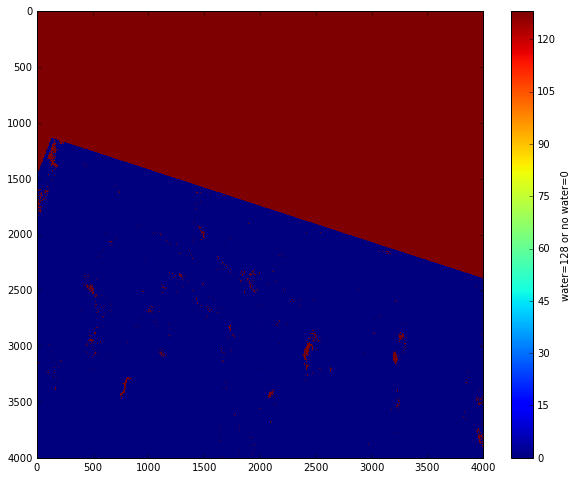

In [34]:
# display all or part of the classified image
plt.imshow(water_classified_img )  #show Lake BurleyGriffin  clfimg[2200:2600,1500:2500]) if cell=(15,-40)
plt.colorbar(orientation='vertical', shrink=0.8, label='water=128 or no water=0');

In [35]:
# The first step produce a very rough water tile as shown above. It even has water in no data region.
# This is why it must be filtered by no_data, cloud, etc. below


# NBAR data

We can use the `nodata` value, or use the contiguous bit in the PQ data to mask out nulls.

Here is `nodata`:

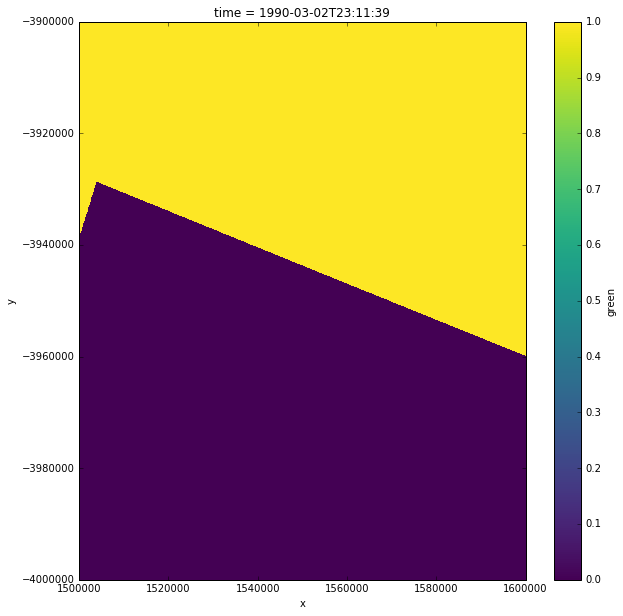

In [36]:
no_data = (nbar_data.green == nbar_data.green.nodata)
no_data.plot()

In [37]:
type(no_data)

xarray.core.dataarray.DataArray

In [38]:
# a mask 1+2D array
no_data

<xarray.DataArray 'green' (time: 1, y: 4000, x: 4000)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 1990-03-02T23:11:39
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...

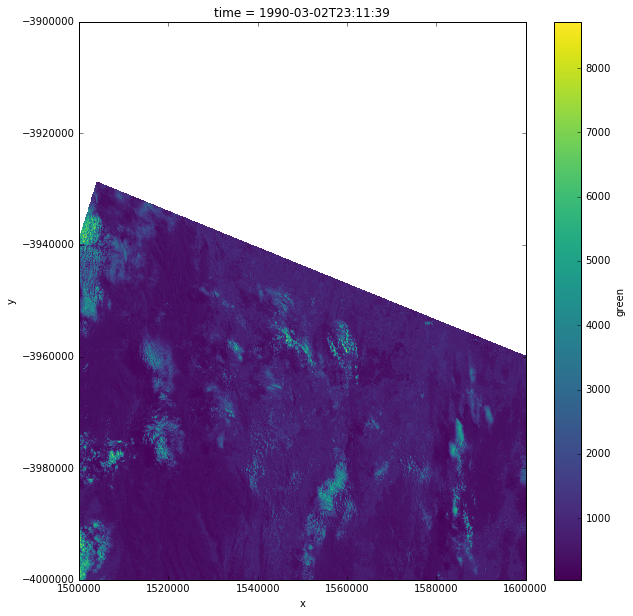

In [39]:
nbar_data.green.where(~no_data).plot()

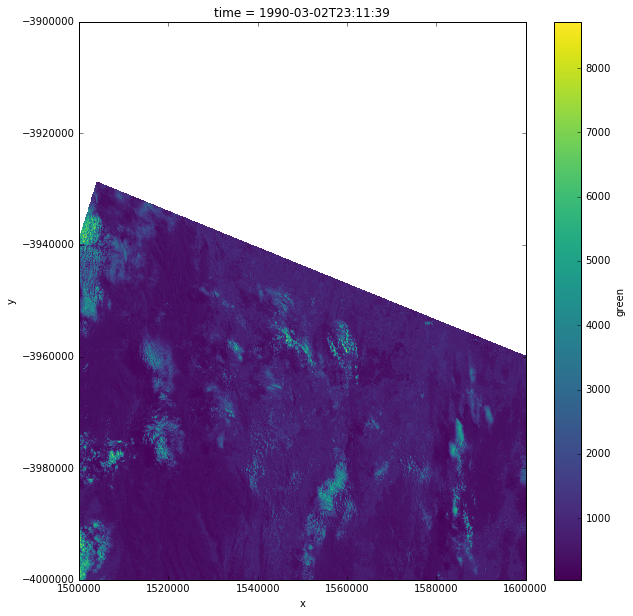

In [40]:
nbar_data.green.where(~ no_data[0]).plot()

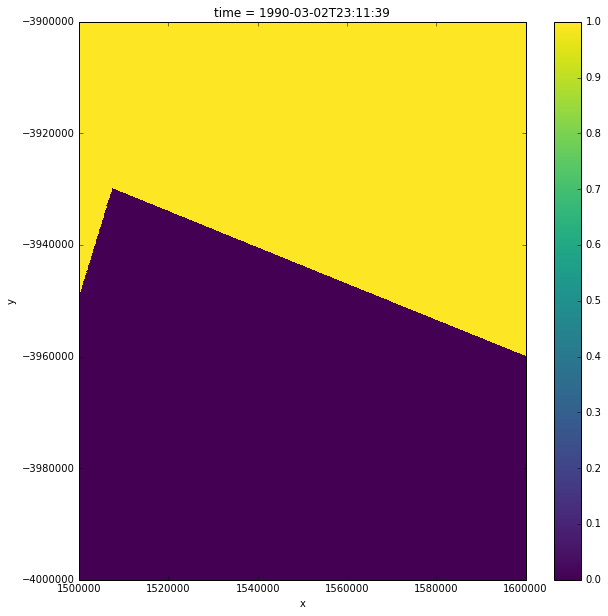

In [41]:
# Get the nodata values for each band (in case they aren't the same)
no_data_values = nbar_data.apply(lambda data_array: data_array.nodata).to_array(dim='band')

# Turn the Dataset into a DataArray, so we can check all bands
stack = nbar_data.to_array(dim='band')

# Find all values that are set to no data, from any band
no_data_mask = (stack == no_data_values).any(dim='band')

no_data_mask.plot()


In [42]:
no_data_mask

<xarray.DataArray (time: 1, y: 4000, x: 4000)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]], dtype=bool)
Coordinates:
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
  * time     (time) datetime64[ns] 1990-03-02T23:11:39

In [43]:
no_data_mask.squeeze()

<xarray.DataArray (y: 4000, x: 4000)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)
Coordinates:
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
    time     datetime64[ns] 1990-03-02T23:11:39

## Load the PQ data:

In [44]:
# cell = key[0]
tile = tile_def[key]['pqa']
pq_data = gw.load( tile)

We can look at the bits available to us:

In [51]:
masking.get_flags_def(pq_data)

{u'blue_saturated': {u'bits': 0,
  u'description': u'Blue band is saturated',
  u'values': {u'0': True, u'1': False}},
 u'cloud_acca': {u'bits': 10,
  u'description': u'Cloud Shadow (ACCA)',
  u'values': {u'0': u'cloud', u'1': u'no_cloud'}},
 u'cloud_fmask': {u'bits': 11,
  u'description': u'Cloud (Fmask)',
  u'values': {u'0': u'cloud', u'1': u'no_cloud'}},
 u'cloud_shadow_acca': {u'bits': 12,
  u'description': u'Cloud Shadow (ACCA)',
  u'values': {u'0': u'cloud_shadow', u'1': u'no_cloud_shadow'}},
 u'cloud_shadow_fmask': {u'bits': 13,
  u'description': u'Cloud Shadow (Fmask)',
  u'values': {u'0': u'cloud_shadow', u'1': u'no_cloud_shadow'}},
 u'contiguous': {u'bits': 8,
  u'description': u'All bands for this pixel contain non-null values',
  u'values': {u'0': False, u'1': True}},
 u'ga_good_pixel': {u'bits': [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
  u'description': u'Best Quality Pixel',
  u'values': {u'16383': True}},
 u'green_saturated': {u'bits': 1,
  u'description': u'Green

In [53]:
# better display using pandas
import pandas
pandas.DataFrame.from_dict(masking.get_flags_def(pq_data), orient='index')

,values,bits,description
blue_saturated,"{u'1': False, u'0': True}",0,Blue band is saturated
cloud_acca,"{u'1': u'no_cloud', u'0': u'cloud'}",10,Cloud Shadow (ACCA)
cloud_fmask,"{u'1': u'no_cloud', u'0': u'cloud'}",11,Cloud (Fmask)
cloud_shadow_acca,"{u'1': u'no_cloud_shadow', u'0': u'cloud_shadow'}",12,Cloud Shadow (ACCA)
cloud_shadow_fmask,"{u'1': u'no_cloud_shadow', u'0': u'cloud_shadow'}",13,Cloud Shadow (Fmask)
contiguous,"{u'1': True, u'0': False}",8,All bands for this pixel contain non-null values
ga_good_pixel,{u'16383': True},"[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",Best Quality Pixel
green_saturated,"{u'1': False, u'0': True}",1,Green band is saturated
land_sea,"{u'1': u'land', u'0': u'sea'}",9,Land or Sea
nir_saturated,"{u'1': False, u'0': True}",3,NIR band is saturated


We can make a mask from a combination of bits. Here we will use the cloud masks and the contiguous bit.

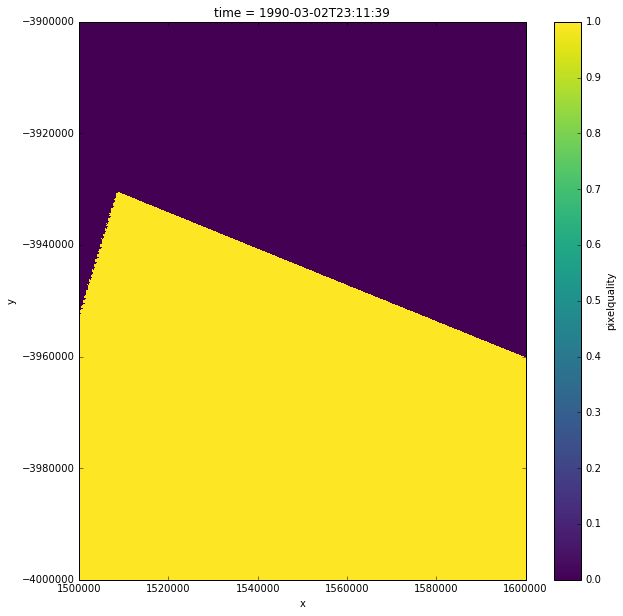

In [54]:
contiguous = masking.make_mask(pq_data, contiguous=1).pixelquality
contiguous.plot()

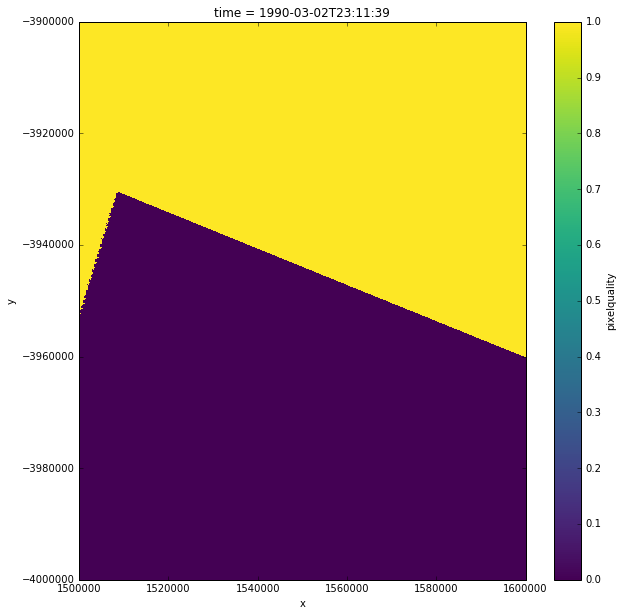

In [55]:
no_contiguous = masking.make_mask(pq_data, contiguous=0).pixelquality
no_contiguous.plot()

In [56]:
# are the same?
np.sum (contiguous != no_contiguous)

<xarray.DataArray 'pixelquality' ()>
array(16000000)

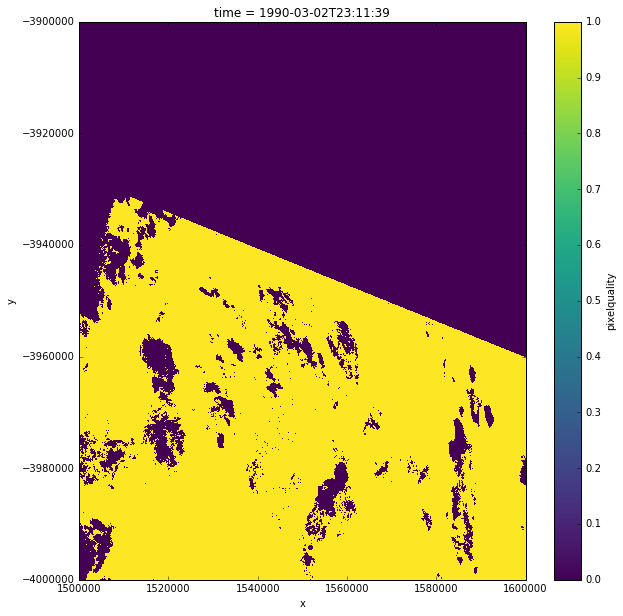

In [57]:
good_data = masking.make_mask(pq_data, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
good_data.plot()

In [58]:
good_data  # is a mask image True/false


<xarray.DataArray 'pixelquality' (time: 1, y: 4000, x: 4000)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]], dtype=bool)
Coordinates:
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
  * time     (time) datetime64[ns] 1990-03-02T23:11:39

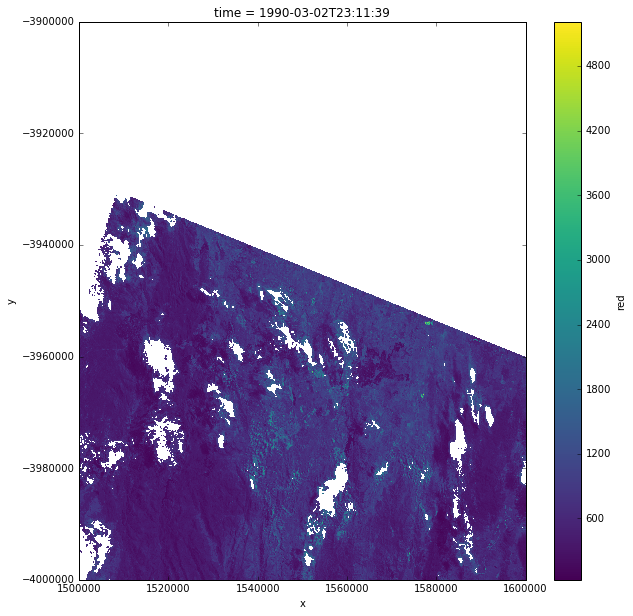

In [59]:
cloud_free_nbar = nbar_data.where(good_data)
cloud_free_nbar.red.plot()

In [60]:
cloud_free_nbar.red

<xarray.DataArray 'red' (time: 1, y: 4000, x: 4000)>
array([[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ..., 
        [  nan,   nan,   nan, ...,  243.,  204.,  204.],
        [  nan,   nan,   nan, ...,  283.,  204.,  204.],
        [  nan,   nan,   nan, ...,  323.,  243.,  204.]]])
Coordinates:
  * time     (time) datetime64[ns] 1990-03-02T23:11:39
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...

# How to mask out the 100% GOOD pixels from NBAR data?

In [61]:
pq_data

<xarray.Dataset>
Dimensions:       (time: 1, x: 4000, y: 4000)
Coordinates:
  * time          (time) datetime64[ns] 1990-03-02T23:11:39
  * y             (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x             (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    pixelquality  (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs: EPSG:3577

perfect_flag 16383


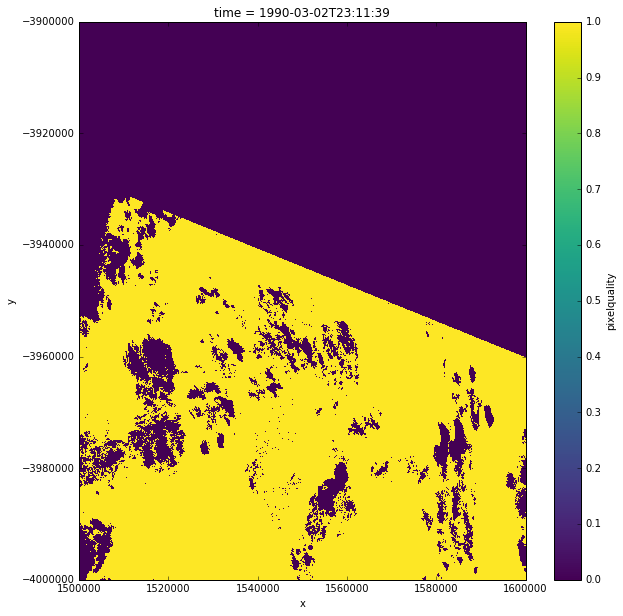

In [62]:
perfect_flag = int(masking.get_flags_def(pq_data)['ga_good_pixel']['values'].keys()[0])   # should be 16383
# perfect_flag = 16383

print ('perfect_flag', perfect_flag)

perfect_pixel_mask=(pq_data.pixelquality == perfect_flag)
perfect_pixel_mask.plot()

In [63]:
perfect_nbar_data = nbar_data.where(perfect_pixel_mask)


In [64]:
y_size=4000
x_size=4000

#del raw_image
raw_image = np.zeros((6, y_size, x_size), dtype='int16') #'float32')

raw_image[0,:,:] = perfect_nbar_data.blue[:,:]
raw_image[1,:,:] = perfect_nbar_data.green[:,:]
raw_image[2,:,:] = perfect_nbar_data.red[:,:]
raw_image[3,:,:] = perfect_nbar_data.nir[:,:]
raw_image[4,:,:] = perfect_nbar_data.swir1[:,:]
raw_image[5,:,:] = perfect_nbar_data.swir2[:,:]


water_img = classifier.classify(raw_image)

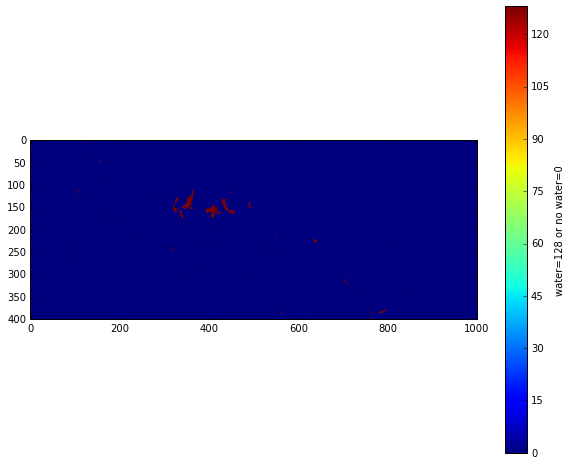

In [65]:
# display all or part of the classified image
#plt.imshow(water_img)
plt.imshow(water_img[2200:2600,1500:2500])  #show Lake BurleyGriffin  clfimg[2200:2600,1500:2500]) if cell=(15,-40)
plt.colorbar(orientation='vertical', shrink=0.8, label='water=128 or no water=0');

In [66]:
water_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [67]:
pq_data

<xarray.Dataset>
Dimensions:       (time: 1, x: 4000, y: 4000)
Coordinates:
  * time          (time) datetime64[ns] 1990-03-02T23:11:39
  * y             (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x             (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    pixelquality  (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs: EPSG:3577

In [68]:
perfect_pixel_mask = masking.make_mask(pq_data, ga_good_pixel=True).pixelquality

In [69]:
perfect_pixel_mask = masking.make_mask(pq_data.pixelquality, ga_good_pixel=True)


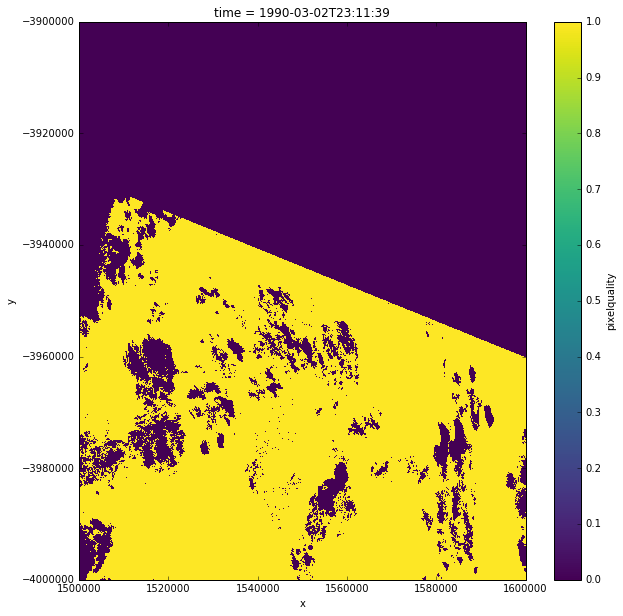

In [75]:
perfect_pixel_mask.plot()

# How to get DSM tiles

In [70]:
acellindex=(15,-40)
dsm_cells = gw.list_tiles(acellindex, product='dsm1sv10')
print (dsm_cells)


defaultdict(<type 'dict'>, {(15, -40, numpy.datetime64('2000-02-12T04:43:00.000000000+1100')): {'geobox': GeoBox(4000, 4000, Affine(25.0, 0.0, 1500000.0,
       0.0, -25.0, -3900000.0), EPSG:3577), 'sources': <xarray.DataArray (time: 1)>
array([ (Dataset <id=a066a2ab-42f7-4e72-bc6d-a47a558b8172 type=dsm1sv10 location=/g/data/v10/projects/ingest_test_data/milestone1/dsm1sv1_0_Clean/agdc-metadata.yaml>,)], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2000-02-11T17:43:00}})


In [71]:
# ----------------------------------------------------------------
def get_dsm_data(acellindex, qdict={}):
    """
    get dsm data for sia, terrainshadow, highslope filters
    :param acellindex:
    :param qdict:
    :return:
    """
    query = qdict.copy()  #avoid modify the original input qdict in-situ
    query.pop('time', None)
    query.pop('platform', None)
    dsm_cells = gw.list_cells(acellindex, product='dsm1sv10', **query)

    def load_dsm(cell):
        data = gw.load(cell)
        return data.squeeze('time').drop('time')

    return {index: load_dsm(cell) for index, cell in dsm_cells.items()}


In [72]:
dsmtile= get_dsm_data(acellindex, qdict={})

In [73]:
print(dsmtile)

{(15, -40): <xarray.Dataset>
Dimensions:    (x: 4000, y: 4000)
Coordinates:
  * y          (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x          (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    elevation  (y, x) float32 582.532 588.824 587.487 584.112 579.31 574.467 ...
Attributes:
    crs: EPSG:3577}


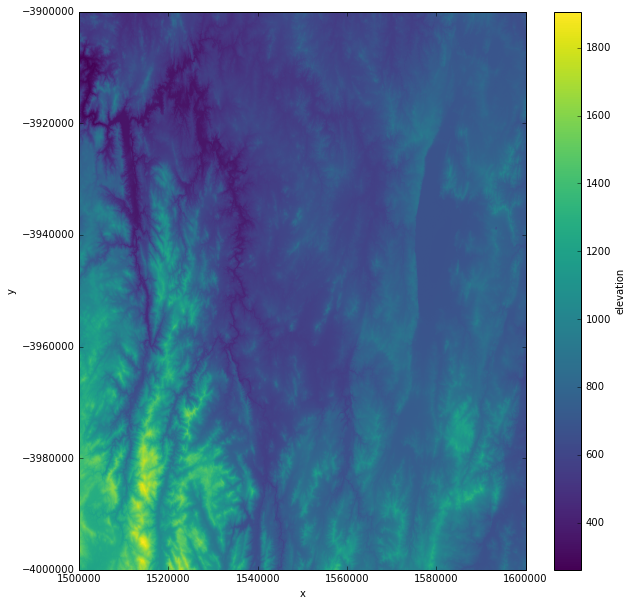

In [74]:

dsmtile[(15,-40)]['elevation'].plot()